# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](../static_files/cifar10.png)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [2]:
# Setup device to compute on
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Device is:', device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
print()

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.train_data[np.where(np.array(trainset.train_labels) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.test_data[np.where(np.array(testset.test_labels) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.train_data = new_train_data
    trainset.train_labels = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.test_data = new_test_data
    testset.test_labels = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2, pin_memory=(device.type=='cuda'))
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2, pin_memory=(device.type=='cuda'))
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Device is: cuda
Files already downloaded and verified
Files already downloaded and verified

used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [6]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [7]:
print("Training data")
print(trainset.train_data.shape)
print(len(trainset.train_labels))
print()

print("Test data")
print(testset.test_data.shape)
print(len(testset.test_labels))
print()

Training data
(50000, 32, 32, 3)
50000

Test data
(10000, 32, 32, 3)
10000



Let us show some of the training images, for fun.



 deer   car  bird  deer


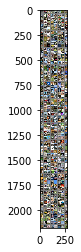

In [8]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [489]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

width = 32
height = 32
channels = 3

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        self.linear_in = 64 * 8 * 8 # Number of features when we finish the conv. part
        
        # We split up the conv. part and the fully connected part so can make a view of x
        # before feeding it to the fully connected part
        
        # Setup conv. part of the network
        self.conv_part = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=64,
                kernel_size=7,
                padding=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=5,
                padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=7,
                padding=3),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=128,
                out_channels=64,
                kernel_size=5,
                padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        # Setup fully connected part of the network
        self.fc_part = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=self.linear_in,
                out_features=100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=100,
                out_features=self.num_classes),
            nn.BatchNorm1d(num_features=self.num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_part(x)  # Do conv. part
        x = x.view(-1, self.linear_in) # Transform to linear input
        return self.fc_part(x) # Do fully connected part
    
net = Net(len(used_categories)).to(device)
print(net)
for param in net.parameters():
    print(param.size())

Device is: cuda
Net(
  (conv_part): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_part): Sequential

In [490]:
# test forward pass on dummy data
x = np.random.normal(0,1, (5, channels, height, width)).astype('float32')
x = Variable(torch.from_numpy(x))
x = x.to(device)
output = net(x)
print(output.size())
output

torch.Size([5, 10])


tensor([[-1.9571, -1.3370, -2.7575, -2.4824, -2.7478, -2.4375, -2.5703, -2.2575,
         -2.5642, -3.2298],
        [-1.4143, -3.2111, -2.5682, -2.5189, -2.6733, -2.6122, -2.5967, -2.6023,
         -2.7208, -1.5969],
        [-3.1909, -2.0068, -2.1208, -2.0898, -2.5610, -3.0941, -2.4692, -2.2940,
         -2.2782, -1.7704],
        [-3.6181, -2.4679, -2.3123, -2.5152, -2.2695, -1.7909, -2.2417, -2.3333,
         -2.2052, -2.0805],
        [-1.8738, -3.0315, -2.2953, -2.4480, -1.8026, -2.1195, -2.1764, -2.5671,
         -2.2858, -3.3767]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [491]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device) # Since we are doing a classification problem
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay=5e-4)

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [492]:
%%time
num_epoch = 35

losses = []
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = torch.zeros(1, requires_grad=False).to(device)
    epoch_loss = torch.zeros(1, requires_grad=False).to(device)
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs = Variable(inputs.to(device, non_blocking=True))
        labels = Variable(labels.to(device, non_blocking=True))

        net.train()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.detach() # Detech loss from its graph
        epoch_loss += loss.detach()
        #if i % 100 == 99:    # print every 100 mini-batches
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 100))
        #    running_loss = 0.0
    
    print('epoch: {}, loss: {}'.format(epoch, epoch_loss.item()))
    losses.append(epoch_loss)

net.eval()
print('Finished Training')

epoch: 0, loss: 176.93716430664062
epoch: 1, loss: 129.90110778808594
epoch: 2, loss: 100.63155364990234
epoch: 3, loss: 84.23457336425781
epoch: 4, loss: 75.57230377197266
epoch: 5, loss: 68.26188659667969
epoch: 6, loss: 64.55766296386719
epoch: 7, loss: 61.164852142333984
epoch: 8, loss: 58.409629821777344
epoch: 9, loss: 56.344581604003906
epoch: 10, loss: 54.30596923828125
epoch: 11, loss: 52.733158111572266
epoch: 12, loss: 51.42656326293945
epoch: 13, loss: 50.72202682495117
epoch: 14, loss: 49.83852005004883
epoch: 15, loss: 47.9293327331543
epoch: 16, loss: 47.70633316040039
epoch: 17, loss: 47.06193923950195
epoch: 18, loss: 46.63701629638672
epoch: 19, loss: 45.8783073425293
epoch: 20, loss: 44.99496078491211
epoch: 21, loss: 44.30364227294922
epoch: 22, loss: 44.18647766113281
epoch: 23, loss: 44.08747100830078
epoch: 24, loss: 42.4974365234375
epoch: 25, loss: 42.34629440307617
epoch: 26, loss: 41.75279998779297
epoch: 27, loss: 41.802581787109375
epoch: 28, loss: 41.15210

## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

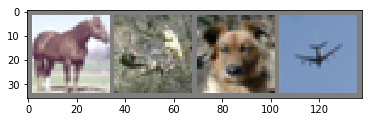

GroundTruth:   horse  frog   dog plane
Predicted:      deer  bird plane truck


In [493]:
images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [494]:
test_correct = 0
test_total = 0
train_correct = 0
train_total = 0

net.eval()
for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum()

for data in trainloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.test_data.shape[0], 100 * test_correct / test_total))

print('Accuracy of the network on the {} training images: {:4.2f} %'.format(
    trainset.train_data.shape[0], 100 * train_correct / train_total))

Accuracy of the network on the 10000 test images: 75.00 %
Accuracy of the network on the 50000 training images: 83.00 %


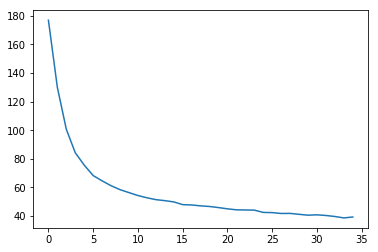

In [496]:
plt.plot(losses)

Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [495]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].cpu().numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 73.20 %
Accuracy of car   : 95.70 %
Accuracy of bird  : 68.50 %
Accuracy of cat   : 58.70 %
Accuracy of deer  : 62.00 %
Accuracy of dog   : 54.20 %
Accuracy of frog  : 91.10 %
Accuracy of horse : 80.30 %
Accuracy of ship  : 84.40 %
Accuracy of truck : 84.30 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

For all my networks I used log-softmax for the final activation. This was inspired by the MNIST cluttered demo. The network parameters are given in the cell below. I used ADAM as my optimizer.

First, I made a simple network with 1 conv. layer, 1 maxpool layer, 1 ReLU layer, and then 2 fully connected layers, with ReLU activation between them. Training ran for 3 epocs. It gave a test accuracy of ~60%.

Next, I added an extra set of conv.- and pooling layers, as well as batch normalization. I also added a weight decay of 1e-4, and trained for 5 epocs, and set the batch size to 64. This gave a test accuracy of ~70% and a training accuracy of ~82%. When I looked at the losses it seemed like more training would be beneficial.

Next, I wanted to confirm that net 2 was better than net 1. So I retrained the net 1 the same way I trained net 2. This gave a test accuracy of 64% and a training accuracy of 75%. So net 2 seems better.

Next, I trained net 2 for 50 epocs. This gave test accuracy of 66% and a training accuracy of 98%, so the network is overfitting. Thus, I upped the regularization.

Next i experimented with different ordering of the layers, adding more layers, different batch sizes, and different hyperparameters. I tried to only change one thing at a time, so I could hopefully pinpoint what helped. The network I ended up with was net 3, shown below. it gave a test accuracy of 75% and a training accuracy of 98%. Looking at the loss plot, it seems like there may have been some benefit to training for longer, but I this is not certain.

My key lessons / insights were:

* It seems like a larger batch size leads to better run times, but does not seem to affect accuracy that much.
* It is **very** important to have good regularization, otherwise you will overfit and lose validation acc.
* Larger networks need to train longer than smaller, likely due to the large number of parameters.
* It seems like it was generally easier to train for "things" such ships, than the mammals. I think this could have something to do with the image backgrounds, since e.g. an image of a ship will likely also have a large blue area in the bottom of the picture, which might be easier to learn. 
* Generally, cats and dogs seem to cause the most trouble. However, of the included classes I would also say that these two are the most similar, and would tend to have similar backgrounds. Thus, this is not entirely unexpected.

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

**Answer**:

I have added support for GPU in the following ways:
* I move my neural net to the GPU.
* I move my loss function to the GPU.
* I move my training batches to the GPU when training, so I train on the GPU.
* I also move batches to the GPU when evaluating.
* I move loss values back to the host, so I can store them.
* I have added the `pin_memory=(device.type=='cuda')` argument to the data loader, so it loads the batches into pinned memory (if the device is set to GPU). This should make host to GPU transfers faster, but I did not really see a speedup.
* I have added the `non_blocking=True` argument, when I transfer training batches to the GPU. Again, this should cause a speedup as it would allow the GPU to also run code while transfering data. However, I did not see an effect.

It seems like most of the time while training is spent on tranferring data to the GPU. Besides what I have tried, I do not know how speed it up. However, I **did** notice a speedup compared to the CPU version.

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:** I chose the exercise in chapter 3:
>Verify that $\sigma'(z) = \sigma(z)(1 - \sigma(z))$.

We know that 
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
Thus, 
$$\sigma'(z) = \frac{e^{-z}}{(1 + e^{-z})^2}.$$
Insertion gives us that
$$
\sigma(z)\left(1 - \sigma(z)\right) = \frac{1}{1 + e^{-z}}\left( 1 - \frac{1}{1 + e^{-z}} \right) = \frac{1}{1 + e^{-z}}\left( \frac{e^{-z}}{1 + e^{-z}} \right) = \frac{e^{-z}}{(1 + e^{-z})^2} = \sigma'(z),
$$
which concludes the proof.
